## Load Data

In [1]:
import pandas as pd

In [3]:
path_to_the_data = 'Data\wiki_movie_plots_deduped.csv'

In [4]:
dataset = pd.read_csv(path_to_the_data)

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


## Select Subset

In [6]:
movies_selected = dataset[dataset['Release Year'] >=2005]

In [9]:
movie_plot = movies_selected['Plot']

In [10]:
movie_plot.head()

14591    Andy Stitzer is a 40-year-old virgin who lives...
14592    51 Birch Street is the first-person account of...
14593    Max is a lonely child in the suburbs of Austin...
14594    In 2011, a deadly pathogenic virus has killed ...
14595    In 1974, Ronald DeFeo Jr. murdered his family ...
Name: Plot, dtype: object

## Split plots into phrases

In [25]:
phrases[10]

'J'

In [26]:
phrases = []

for plot in movie_plot.head(1000):
    phrases_all = plot.split('.')
    phrases_filtered = [p.strip() for p in phrases_all if p.strip() and len(p.strip())>3]
    phrases += phrases_filtered
    

In [27]:
from textacy.extract import subject_verb_object_triples

In [28]:
import spacy
pre_trained_spacy_model = spacy.load('en_core_web_sm')

In [29]:
doc = pre_trained_spacy_model("I am eating an apple")
iterator = subject_verb_object_triples(doc)

for item in iterator:
    print(item)


SVOTriple(subject=[I], verb=[am, eating], object=[apple])


## Extract the SVO triples from the phrases

In [30]:
from tqdm import tqdm #used to show the time and progrss 

In [32]:
triples_raw = []

for p in tqdm(phrases):
    iterator = subject_verb_object_triples(pre_trained_spacy_model(p))
    phrases_triples = []
    
    for svo in iterator:
        
        phrases_triples.append(svo)
        
    triples_raw.append(phrases_triples)


100%|████████████████████████████████████████████████████████████████████████████| 28127/28127 [07:16<00:00, 64.44it/s]


In [33]:
triples_raw[:10]

[[],
 [SVOTriple(subject=[him], verb=[lose], object=[virginity])],
 [SVOTriple(subject=[men], verb=[give], object=[Andy, advice])],
 [SVOTriple(subject=[Cal], verb=[advises], object=[Andy]),
  SVOTriple(subject=[he], verb=[practices], object=[which]),
  SVOTriple(subject=[who], verb=[becomes, intrigued], object=[him])],
 [SVOTriple(subject=[David], verb=[gives], object=[porn, collection])],
 [SVOTriple(subject=[Mooj], verb=[stresses], object=[importance])],
 [SVOTriple(subject=[Andy], verb=[begins], object=[to, socialize, and, form, friendships, with, his, co, -])],
 [SVOTriple(subject=[David], verb=[has], object=[breakdown])],
 [SVOTriple(subject=[manager, Paula], verb=[promotes], object=[Andy])],
 [SVOTriple(subject=[Jay], verb=[attempts], object=[to, quicken, the, process, by, tricking, Andy, into, meeting, a, prostitute])]]

## Lemmatize and Stem SVO triples

In [34]:
from nltk.stem import WordNetLemmatizer,SnowballStemmer #for lemmatization and stemming respectively

In [40]:
from nltk.corpus.reader.wordnet import VERB

In [41]:
def return_stemmed_lemmatized_token(token):
    lemmatizer = WordNetLemmatizer()
    stemmer = SnowballStemmer(language = 'english')
    
    lemmatized_token = lemmatizer.lemmatize(token, pos='v')
    
    stemmed_token = stemmer.stem(lemmatized_token)
    
    return stemmed_token

In [46]:
phrase_counter = 0
found_triples_counter = 0
lemmatized_triples = []
lemmatized_stemmed_triples = []

lemmatizer = WordNetLemmatizer()

for (phrase,phrase_triples) in zip(phrases,triples_raw):
    
    if len(phrase) > 0:
        phrase_counter +=1
        
    if phrase_triples:
        found_triples_counter +=1
        
        for triple in phrase_triples:
            
            #lemmatize
            sub = lemmatizer.lemmatize(str(triple[0]))
            obj = lemmatizer.lemmatize(str(triple[2]))
            verb = lemmatizer.lemmatize(str(triple[1][-1]),VERB)
            
            #lemmatize and stem
            sub_ls = return_stemmed_lemmatized_token(str(triple[0]))
            obj_ls = return_stemmed_lemmatized_token(str(triple[2]))
            verb_ls = return_stemmed_lemmatized_token(str(triple[1][-1]))
            
            
            lemmatized_triples.append([sub.lower(),verb.lower(),obj.lower()])
            lemmatized_stemmed_triples.append([sub_ls.lower(),verb_ls.lower(),obj_ls.lower()])
            
    else:
        lemmatized_triples.append([])
        lemmatized_stemmed_triples.append([])
        
            
            
            

Textacy lib is not always successfully able to detect triples , hence checking the conversion rate in our case

In [48]:
print("Detection Rate: ", (found_triples_counter)/phrase_counter)

Detection Rate:  0.7365876204358801


# Create Graph

Create SVO dataframe

In [54]:
import networkx as nx

In [57]:
import matplotlib.pyplot as plt

In [49]:
sources = []
relations = []
targets = []


In [50]:
for ep_item in lemmatized_stemmed_triples:
    
    #check if items not found in list
    if ep_item:
        sources.append(ep_item[0])
        relations.append(ep_item[1])
        targets.append(ep_item[2])
        

In [64]:
KG_df = pd.DataFrame({'source':sources,'edge':relations,'target':targets})

In [65]:
KG_df.tail()

,source,edge,target
35937,[he],encount,[prisoner]
35938,[he],save,[whom]
35939,[man],exclaim,[prisoner]
35940,[mcdonagh],save,[life]
35941,[mcdonagh],escap,[addiction]


In [76]:
# create a directed-graph from a dataframe
G= nx.from_pandas_edgelist(KG_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())

In [78]:
len(G)

18862

In [67]:
# Visualize a single relation as knowledge Graph
G_single_edge = nx.from_pandas_edgelist(KG_df[KG_df['edge']=='escap'], "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())


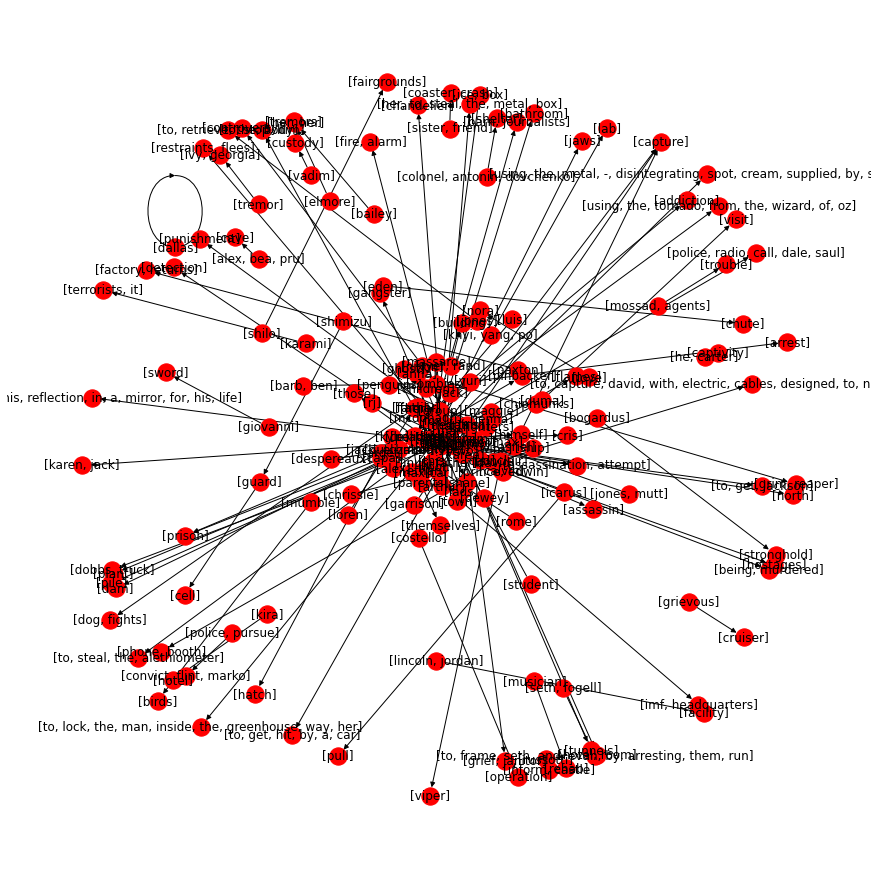

In [68]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G_single_edge, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

## Top 25 subjects in the movie plots

<AxesSubplot:>

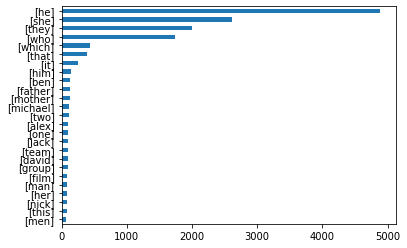

In [70]:
KG_df.source.value_counts()[:25].sort_values().plot.barh()

## Top 25 Object in the movie plots

<AxesSubplot:>

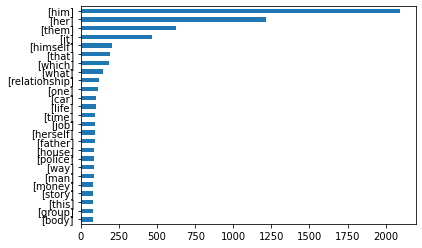

In [71]:
KG_df.target.value_counts()[:25].sort_values().plot.barh()

## Top 25 verb in the movie plots

<AxesSubplot:>

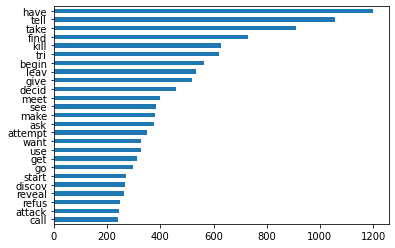

In [72]:
KG_df.edge.value_counts()[:25].sort_values().plot.barh()

## Exploring the Relations that exists between the most popular subject and the object

In [88]:
edges = [v['edge'] for k,v in G.get_edge_data('[he]','[him]').items()]

In [90]:
G.edges

OutMultiEdgeView([('[him]', '[virginity]', 0), ('[him]', '[trish, himself]', 0), ('[him]', '[sex]', 0), ('[him]', '[scarecrow, mask, falcone]', 0), ('[him]', '[role]', 0), ('[him]', '[role]', 1), ('[him]', '[shirts]', 0), ('[him]', '[photographs]', 0), ('[him]', '[father]', 0), ('[him]', '[enlargement, pump]', 0), ('[him]', '[fireflys]', 0), ('[him]', '[relationship]', 0), ('[him]', '[relationship]', 1), ('[him]', '[rest]', 0), ('[him]', '[bolts]', 0), ('[him]', '[fowler]', 0), ('[him]', '[tapes]', 0), ('[him]', '[body]', 0), ('[him]', '[night, stand]', 0), ('[him]', '[reflection]', 0), ('[him]', '[identity]', 0), ('[him]', '[identity]', 1), ('[him]', '[her]', 0), ('[him]', '[her]', 1), ('[him]', '[her]', 2), ('[him]', '[her]', 3), ('[him]', '[her]', 4), ('[him]', '[her]', 5), ('[him]', '[her]', 6), ('[him]', '[her]', 7), ('[him]', '[north]', 0), ('[him]', '[him]', 0), ('[him]', '[him]', 1), ('[him]', '[him]', 2), ('[him]', '[hunger]', 0), ('[him]', '[sacrifice[clarification]', 0), ('[

In [89]:
edges

['fight',
 'persuad',
 'stop',
 'react',
 'escort',
 'disappear',
 'subdu',
 'see',
 'do',
 'go',
 'see',
 'marri',
 'blame',
 'accept',
 'lock',
 'buri',
 'molest',
 'tell',
 'tell',
 'retreat',
 'owe',
 'find',
 'forgiv',
 'interrog',
 'kill',
 'treat',
 'help',
 'direct',
 'discov',
 'hat',
 'rap',
 'invit',
 'love',
 'turn',
 'interrog',
 'tell',
 'befriend',
 'discov',
 'pursu',
 'nurs',
 'visit',
 'save',
 'leav',
 'forgiv',
 'deduc',
 'anger',
 'lung',
 'tell',
 'attack',
 'convinc',
 'incapacit',
 'tell',
 'tell',
 'want',
 'explain',
 'confid',
 'encourag',
 'send',
 'leav',
 'mimic',
 'confront',
 'captur',
 'confront',
 'tell',
 'disarm',
 'place',
 'push',
 'love',
 'refus',
 'reach',
 'tell',
 'leav',
 'drop',
 'put',
 'shoot',
 'shoot',
 'relent',
 'recov',
 'crush',
 'leav',
 'gun',
 'get',
 'pay',
 'leav',
 'lie',
 'knock',
 'embrac',
 'do',
 'cut',
 'ask',
 "n't",
 'reveal',
 'assault',
 'warn',
 'pay',
 'place',
 'help',
 'leav',
 'treat',
 'disciplin',
 'challeng',
 

## Depth First Search

In [ ]:
# selecting the relation 'tell' or 'ask'
selected_nodes = [n for (n,v,e)]